Ao aplicar Análise Exploratória de Dados vou responder a estas 10 perguntas:

- 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?
- 2- Qual o Número de Títulos Por Gênero?
- 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?
- 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?
- 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
- 6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.
- 7- Qual a Relação Entre Duração e Gênero?
- 8- Qual o Número de Filmes Produzidos Por País?
- 9- Quais São os Top 10 Melhores Filmes?
- 10- Quais São os Top 10 Piores Filmes?

# Instalando e Carregando Pacotes

In [1]:
# Versão de  linguagem Python
from platform import python_version
print('Versão da Python usada Neste Jupyter Notebook:', python_version())

Versão da Python usada Neste Jupyter Notebook: 3.8.5


In [2]:
#instalar pacote
!pip install -q imdb-sqlite

In [3]:
#instalar o pacote com os paises.
!pip install -q pycountry

In [4]:
import re #pacete de expreção regulares em texto - processa texto
import time #para medir o tempo de exec ou trab com datas
import sqlite3 #pacote para manipular banco de dados
import pycountry#pacote com os paises
import numpy as np#manipulação de dados
import pandas as pd#manipulação de dados
import matplotlib.pyplot as plt #visualização de dados graficos
import seaborn as sns# visualização de dados graficos
from matplotlib import cm# visualização de dados graficos
from sklearn.feature_extraction.text import CountVectorizer#"skylearn" machine learnig python.
import warnings# filtra qualquer tipo warnings
warnings.filterwarnings("ignore")#filtra qualquer tipo de warnings
sns.set_theme(style ="whitegrid")#definição de estilo 'tema' Graficos

# Carregando os Dados
#### primeiro temos que baixa os dados!

In [5]:
%%time
!imdb-sqlite

Wall time: 437 ms


2021-07-31 18:40:07,685 DB already exists: (imdb.db). Refusing to modify. Exiting


In [6]:
#conectar no banco de dados
conn = sqlite3.connect("imdb.db")

In [8]:
# Extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [9]:
# tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [11]:
# visualizar tabela
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [12]:
#convertendo essa tabela"dataframe" em lista
tabelas = tabelas['Table_Name'].values.tolist()

In [13]:
# Vamos percorrer a lista de tabelas no banco de dados e extrair o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




# 1- Quais são as Categorias de Filmes mais Comuns no IMDB?
##### Quais são as principais tipos (Categorias) dos títulos (filmes)?

In [14]:
#Cria a consulta SQL
consulta1 = '''Select type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [15]:
# Extrai o resultado
resultado1 = pd.read_sql_query(consulta1,conn)

In [17]:
# Visualizar o resultado
display(resultado1)

,type,COUNT
0,movie,583611
1,radioEpisode,1
2,radioSeries,1
3,short,823052
4,tvEpisode,5947324
5,tvMiniSeries,38517
6,tvMovie,132326
7,tvSeries,211605
8,tvShort,10156
9,tvSpecial,33482


In [19]:
# Vamos calcular o percentual para cada tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [20]:
# Visualiza o resultado
display(resultado1)

,type,COUNT,percentual
0,movie,583611,7.183350
1,radioEpisode,1,0.000012
2,radioSeries,1,0.000012
3,short,823052,10.130499
4,tvEpisode,5947324,73.202375
5,tvMiniSeries,38517,0.474085
6,tvMovie,132326,1.628729
7,tvSeries,211605,2.604531
8,tvShort,10156,0.125005
9,tvSpecial,33482,0.412112


In [21]:
# Vamos cria um gráfico com apenas 4 categorias:
# As 3 categorias com mais títulos e 1 categoria com todo o restante

#Cria um dicionário vazio
others = {}

#Filtra o percentual em 5% e soma o total
others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

# Grava o percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

#Ajusta o nome
others['type'] = 'others'

In [22]:
# Visualiza
others

{'COUNT': 770509, 'percentual': 9.483775978226834, 'type': 'others'}

In [23]:
# Filtra o dataframe de resultado
resultado1 = resultado1[resultado1['percentual']> 5]

In [24]:
# Append com o dataframe de outras categorias
resultado1 = resultado1.append(others, ignore_index = True)

In [25]:
# Ordena o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [26]:
#visualiza
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,5947324,73.202375
1,short,823052,10.130499
3,others,770509,9.483776
0,movie,583611,7.183350


In [27]:
# Ajusta os labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

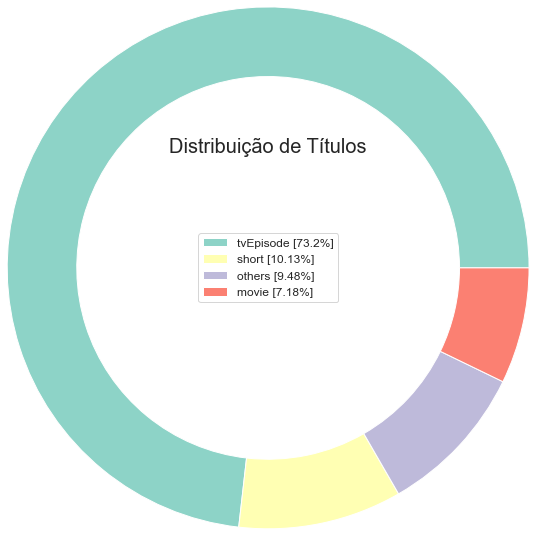

In [28]:
# plot

#Mapa de cores
#https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

#Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

# Qual o número de Títulos por Gênero?
#### Vamos calcular o número de filmes por gênero e entregar o resultado em valor percentual.

In [29]:
# Cria a consulta SQL
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

In [30]:
# Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

In [31]:
# Visualiza o resultado
display(resultado2)

,genres,COUNT(*)
0,Action,13281
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1439,"Thriller,Western",37
1440,War,1249
1441,"War,Western",9
1442,Western,4033


In [32]:
# Converte as strings para minusculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [33]:
# Remove valores NA (ausentes)
temp = resultado2['genres'].dropna()

In [34]:
# Vamos criar um vetor usando expressão regular para filtrar as strings
# https://docs.python.org/3.8/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'


# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [35]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [36]:
# Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [37]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [38]:
# Retorna gêneros únicos
generos_unicos = vetor.get_feature_names()

In [39]:
# Cria o dataframa de Gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [40]:
# Visualiza
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1444 entries, 0 to 1443
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1444 non-null   int64
 1   adult        1444 non-null   int64
 2   adventure    1444 non-null   int64
 3   animation    1444 non-null   int64
 4   biography    1444 non-null   int64
 5   comedy       1444 non-null   int64
 6   crime        1444 non-null   int64
 7   documentary  1444 non-null   int64
 8   drama        1444 non-null   int64
 9   family       1444 non-null   int64
 10  fantasy      1444 non-null   int64
 11  film-noir    1444 non-null   int64
 12  game-show    1444 non-null   int64
 13  history      1444 non-null   int64
 14  horror       1444 non-null   int64
 15  music        1444 non-null   int64
 16  musical      1444 non-null   int64
 17  mystery      1444 non-null   int64
 18  n            1444 non-null   int64
 19  news         1444 non-null   int64
 20  reality-

In [41]:
# Drop da coluna n
generos = generos.drop(columns = 'n', axis = 0)

In [42]:
# Calcula o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [43]:
# Visualiza
generos_percentual.head(10)

drama          18.421053
comedy         16.828255
documentary    15.997230
adventure      14.889197
action         14.612188
romance        13.504155
crime          13.019391
mystery        12.603878
thriller       12.396122
fantasy        12.257618
dtype: float64

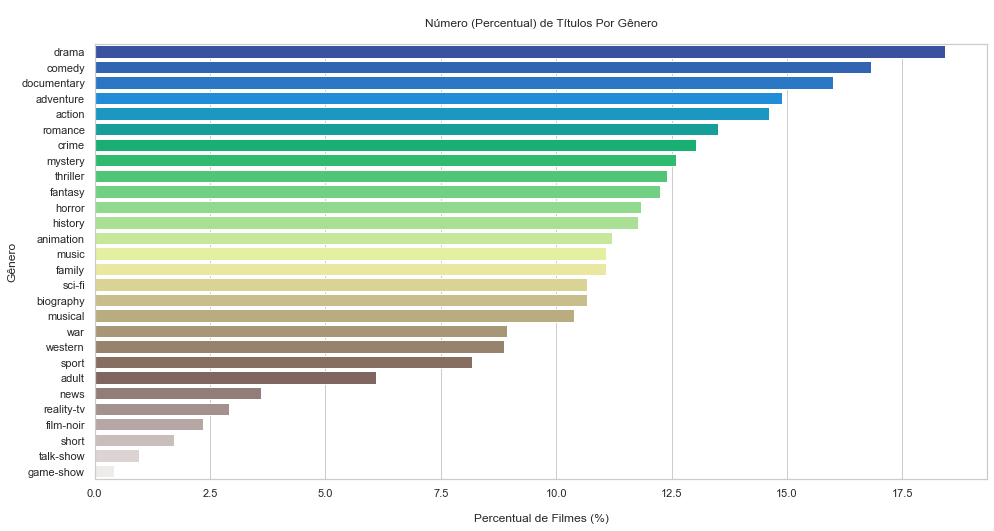

In [44]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

## 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?

Mediana de avaliação dos filmes.

In [45]:
# Consulta SQL
consulta3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ''' 

In [46]:
# Resultado
resultado3 = pd.read_sql_query(consulta3, conn)

In [47]:
#Visualizar
display(resultado3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
266340,3.5,"Action,Adventure,Thriller"
266341,5.8,Thriller
266342,6.3,"Adventure,Drama,History"
266343,3.8,"Adventure,History,War"


In [48]:
# Vamos criar uma função para retornar os genêros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [49]:
# Aplica a função
generos_unicos = retorna_generos(resultado3)

In [50]:
# Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [52]:
# Cria listas vazias
genero_counts = []
genero_ratings = []

In [53]:
# Loop
for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [54]:
# Prepara o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [55]:
# Visualiza
df_genero_ratings.head(20)

,genres,count,rating
0,action,28616,5.80
1,adult,4078,5.80
2,adventure,17576,6.00
3,animation,4640,6.40
4,biography,7995,7.00
5,comedy,66480,6.00
6,crime,22982,6.10
7,documentary,38930,7.30
8,drama,118276,6.30
9,family,10131,6.30


In [56]:
# Drop do índice 18 (news)
# Não queremos essa informação como gênero
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [57]:
# Ordena o resultado
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

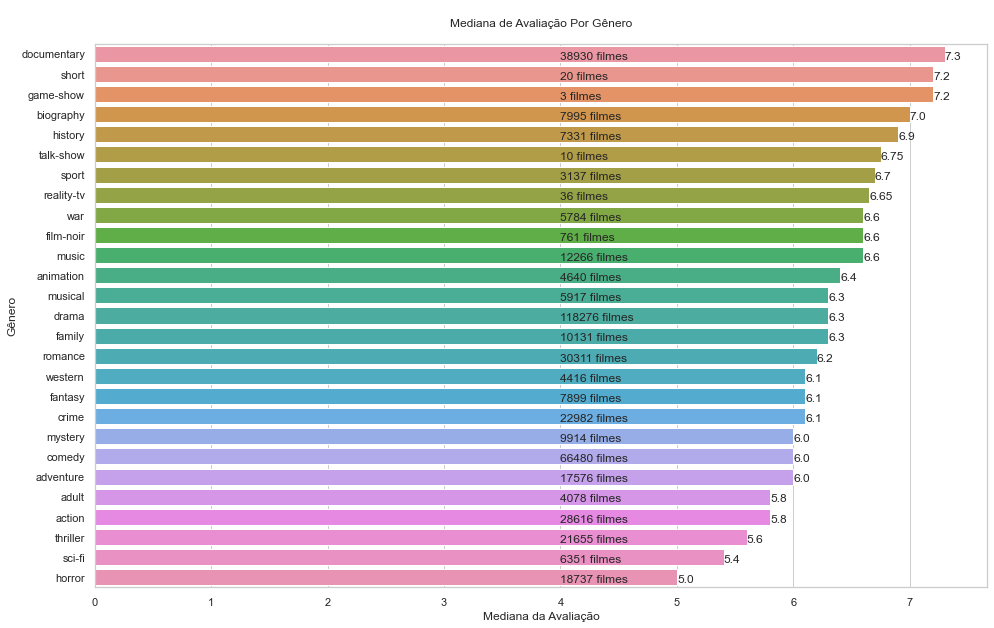

In [58]:
# Plot

# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

## 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

Mediana de avaliação dos filmes.

In [59]:
# Consulta SQL
consulta4 = '''
            SELECT rating AS Rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            ''' 

In [60]:
# Resultado
resultado4 = pd.read_sql_query(consulta4, conn)

In [61]:
# Calculamos a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [62]:
type(ratings)

list

In [63]:
ratings[1:10]

[4.4, 3.8, 6.15, 4.5, 3.5, 4.6, 5.4, 4.3, 3.6]

In [64]:
# Lista de anos
anos = list(set(resultado4['premiered']))

In [65]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

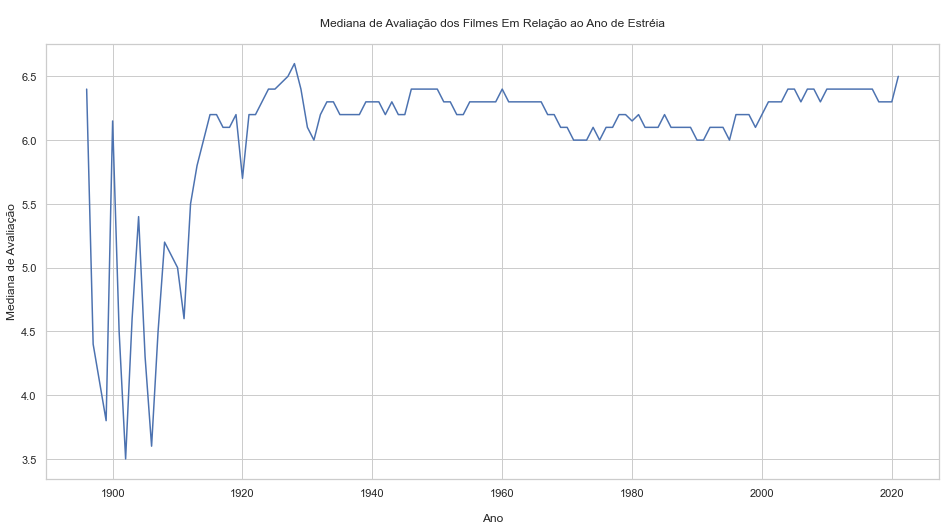

In [66]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()